In [164]:
"""
=========================================================================================
PROJECT: LANDSLIDE DETECTION LSTM PIPELINE (Refined Version)
โครงการ: ระบบตรวจจับดินถล่มด้วยโมเดล LSTM (ฉบับปรับปรุง)
=========================================================================================

[OBJECTIVE / วัตถุประสงค์]
English: Build an AI model (LSTM) to predict landslide risks (Normal, Warning, Critical)
         using time-series sensor data (Soil, Rain, Temp, Humi, Geo). 
         Key focus: Correctly handling time gaps and class imbalance.
Thai:    สร้างโมเดล AI (LSTM) เพื่อทำนายโอกาสเกิดดินถล่ม โดยเรียนรู้จากข้อมูล Time-series
         ของ Sensor เน้นการจัดการเรื่องเวลาขาดหาย (Time Gaps) และข้อมูลไม่สมดุล (Imbalance) อย่างถูกต้อง

-----------------------------------------------------------------------------------------
PIPELINE OVERVIEW / ภาพรวมการทำงาน
-----------------------------------------------------------------------------------------

1. CONFIGURATION & SETUP
   [EN] Define file paths for Training (File A) and Validation (File B), and Hyperparameters.
   [TH] กำหนด Path ไฟล์ Training (File A) และ Validation (File B) รวมถึง Hyperparameters ต่างๆ

2. DATA LOADING & CLEANING (Cell 3)
   [EN] Load raw data, normalize columns, and **Fix Timestamps** (Reconstruct continuous time index).
   [TH] โหลดข้อมูลดิบ, ปรับชื่อ Column, และ **Fix Timestamps** (สร้าง Time Index ใหม่ให้ต่อเนื่อง)

3. RESAMPLING & FILLING (Cell 4) **[CRITICAL FIX]**
   [EN] Systematically resample to 1-minute intervals. 
        - Numeric: Use Mean. 
        - Label: Use First/Mode (to prevent label loss).
        - Apply Interpolation to fill missing values.
   [TH] แปลงข้อมูลเป็นราย 1 นาที (1-min interval) อย่างเป็นระบบ
        - ข้อมูลตัวเลข: ใช้ค่าเฉลี่ย (Mean)
        - ข้อมูล Label: ใช้ค่าแรก (First) เพื่อป้องกัน Label หาย
        - ใช้ Interpolation อุดรูรั่วของข้อมูล

4. FEATURE ENGINEERING (Cell 6)
   [EN] (Optional) Add features from pre-trained Autoencoder/Isolation Forest (e.g., ae_seq_mae).
   [TH] (Optional) สร้างฟีเจอร์เพิ่มจากโมเดล Autoencoder/Isolation Forest เช่น ค่าความผิดปกติ (ae_seq_mae)

5. STRATIFIED DEVICE SPLIT (Cell 7)
   [EN] Split Train/Test based on **Device ID** (Strict separation to prevent leakage):
        - Train Set: 90% of devices in File A.
        - Test Set:  10% of devices in File A (Unseen Devices).
        - Validation Set: All data from File B (Specific Scenario).
   [TH] แบ่งข้อมูล Train/Test โดยใช้ **Device ID** เป็นเกณฑ์ (ป้องกัน AI จำข้อสอบ):
        - Train Set: 90% ของ Device ใน File A
        - Test Set:  10% ของ Device ใน File A (เครื่องที่ไม่เคยเห็นมาก่อน)
        - Validation Set: ใช้ข้อมูลทั้งหมดจาก File B (สถานการณ์ฝน 6 ชม.)

6. SEQUENCE GENERATION (Cell 8)
   [EN] Convert 2D tabular data to 3D Arrays (Samples, 30 TimeSteps, Features) using Sliding Window.
   [TH] แปลงข้อมูลตาราง 2D เป็น 3D Array สำหรับ LSTM โดยใช้ Sliding Window เลื่อนทีละ 1 นาที

7. IMBALANCE HANDLING (Cell 9 & 11)
   [EN] **Oversampling:** Duplicate 3D sequences for Critical/Warning classes. 
        **Class Weights:** Assign higher weights to rare classes during training.
   [TH] **Oversampling:** สุ่มเพิ่มข้อมูลช่วง Critical/Warning (Copy ทั้งก้อน 3D) 
        และใช้ **Class Weights** เพื่อให้ AI ให้ความสำคัญกับคลาสที่หายาก

8. MODEL TRAINING (Cell 12-13)
   [EN] Architecture: LSTM -> LSTM -> Dropout -> Dense. 
        Callbacks: EarlyStopping and ReduceLROnPlateau.
   [TH] โครงสร้าง: LSTM 2 ชั้น + Dropout. ใช้ Callbacks: EarlyStopping และ ReduceLROnPlateau

9. EVALUATION (Cell 14)
   [EN] Evaluate on Test Set (Unseen Devices) and Validation Set (Scenario). Show Confusion Matrix.
   [TH] วัดผลแยก 2 ส่วน: Test Set (เครื่องใหม่) และ Validation Set (สถานการณ์จำลอง) แสดง Confusion Matrix

=========================================================================================
"""

'\n=========================================================================================\nPROJECT: LANDSLIDE DETECTION LSTM PIPELINE (Refined Version)\nโครงการ: ระบบตรวจจับดินถล่มด้วยโมเดล LSTM (ฉบับปรับปรุง)\n=========================================================================================\n\n[OBJECTIVE / วัตถุประสงค์]\nEnglish: Build an AI model (LSTM) to predict landslide risks (Normal, Warning, Critical)\n         using time-series sensor data (Soil, Rain, Temp, Humi, Geo). \n         Key focus: Correctly handling time gaps and class imbalance.\nThai:    สร้างโมเดล AI (LSTM) เพื่อทำนายโอกาสเกิดดินถล่ม โดยเรียนรู้จากข้อมูล Time-series\n         ของ Sensor เน้นการจัดการเรื่องเวลาขาดหาย (Time Gaps) และข้อมูลไม่สมดุล (Imbalance) อย่างถูกต้อง\n\n-----------------------------------------------------------------------------------------\nPIPELINE OVERVIEW / ภาพรวมการทำงาน\n-----------------------------------------------------------------------------------------\n\n1. CONFIGURAT

In [165]:
# ====================================================================
# CELL 1: IMPORTS & CONFIG
# ====================================================================
import re
import os
import random
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')
print("✓ Imports OK")

class Config:
    # File paths - ปรับให้ตรงเครื่องคุณ
    TRAIN_PATH = "../../data/final_label_data_training_moving_avg.csv"
    VAL_PATH   = "../../data/final_moving_avg_devID109_rain_6_hour.csv"
    
    # Optional pretrained models
    AE_MODEL_PATH = "./../LSTM_Autoencoders/lstm_autoencoder_model_fit.h5"
    AE_SCALER_PATH = "./../LSTM_Autoencoders/scaler_fit.save"
    ISO_SCALER_PATH = "./../IsalationForest/model/iso_scaler.joblib"
    ISO_MODEL_PATH = "./../IsalationForest/model/iso_model.joblib"
    
    # outputs
    OUTPUT_MODEL = "lstm_supervised_by_dev.h5"
    OUTPUT_SCALER = "scaler_supervised.save"
    OUTPUT_TRAIN_DEVS = "train_devs.csv"
    OUTPUT_TEST_DEVS  = "test_devs.csv"
    OUTPUT_TEST_META  = "test_sequence_meta.csv"
    OUTPUT_VAL_META   = "validation_devID109_meta.csv"
    
    # features / labels
    NUMERIC_COLS = ['soil','rain','temp','humi','geo']
    LABEL_COL = 'label'
    LABEL_MAP = {'normal':0, 'warning':1, 'critical':2}
    
    # seq / model
    SEQUENCE_LENGTH = 30
    TRAIN_DEV_RATIO = 0.9
    RANDOM_SEED = 42
    OVERSAMPLE_FRACTION = 0.6
    LSTM_UNITS = [128,64]
    DROPOUT_RATE = 0.3
    LEARNING_RATE = 1e-3
    BATCH_SIZE = 64
    MAX_EPOCHS = 100
    EARLY_STOP_PATIENCE = 8
    LR_REDUCE_PATIENCE = 4

cfg = Config()
np.random.seed(cfg.RANDOM_SEED); random.seed(cfg.RANDOM_SEED)
print("✓ Config loaded")

✓ Imports OK
✓ Config loaded


In [166]:
# ====================================================================
# CELL 2: UTILITIES
# ====================================================================
def normalize_and_map_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Clean column names
    df.columns = [str(c).lower().strip().replace('.1', '') for c in df.columns]
    
    rename_map = {
        'temperature':'temp','temp':'temp',
        'hum':'humi','humidity':'humi','humi':'humi',
        'devid':'devID','deviceid':'devID','device_id':'devID','device':'devID','node':'devID',
        'time':'timestamp','timestamp':'timestamp','date':'timestamp'
    }
    # Apply map strictly
    new_cols = {}
    for c in df.columns:
        if c in rename_map:
            new_cols[c] = rename_map[c]
    if new_cols:
        df = df.rename(columns=new_cols)
    return df

def parse_timestamp_series(s: pd.Series) -> pd.Series:
    # Convert to datetime, forcing coercion
    ts = pd.to_datetime(s, errors='coerce', infer_datetime_format=True)
    return ts

def normalize_dev_id_series(s: pd.Series) -> pd.Series:
    def to_id(x):
        if pd.isna(x): return x
        s_val = str(x).strip()
        # extract numbers e.g. 'Node 109' -> 109
        m = re.search(r'(\d+)', s_val)
        if m:
            try: return int(m.group(1))
            except: return m.group(1)
        return s_val
    return s.apply(to_id)

def show_head(df, name="df", n=3):
    print(f"--- {name} shape={df.shape} columns={list(df.columns)}")
    if not df.empty:
        print(df.head(n).to_string(index=False))
    else:
        print("   (Empty DataFrame)")

In [167]:
# ====================================================================
# CELL 3: LOAD + NORMALIZE + PER-DEVICE TIMESTAMP FIX
# ====================================================================
print("\n=== LOAD RAW CSVs ===")
df_train_raw = pd.read_csv(cfg.TRAIN_PATH)
df_val_raw   = pd.read_csv(cfg.VAL_PATH)
print("Loaded raw shapes -> train:", df_train_raw.shape, "val:", df_val_raw.shape)

# Normalize columns
df_train_raw = normalize_and_map_columns(df_train_raw)
df_val_raw   = normalize_and_map_columns(df_val_raw)

# Ensure numeric cols
for c in cfg.NUMERIC_COLS:
    if c not in df_train_raw.columns:
        print(f"⚠ train missing '{c}', creating zeros")
        df_train_raw[c] = 0.0
    if c not in df_val_raw.columns:
        print(f"⚠ val missing '{c}', creating zeros")
        df_val_raw[c] = 0.0

# Normalize devID
df_train_raw['devID'] = normalize_dev_id_series(df_train_raw['devID'])
df_val_raw['devID']   = normalize_dev_id_series(df_val_raw['devID'])

# Ensure timestamps per device
def ensure_per_device_timestamps(df: pd.DataFrame, freq='1T') -> pd.DataFrame:
    df = df.copy()
    if 'timestamp' not in df.columns:
        df['timestamp'] = pd.NaT
    
    df['timestamp'] = parse_timestamp_series(df['timestamp'])
    
    parts = []
    for dev, g in df.groupby('devID', sort=False):
        g = g.reset_index(drop=True)
        
        # If mostly NaT, generate entirely new index
        valid_ts = g['timestamp'].dropna()
        if len(valid_ts) == 0:
            start = pd.Timestamp('2025-01-01 00:00:00')
            print(f"  • Device {dev}: No valid timestamps. Generating from {start}")
            g['timestamp'] = pd.date_range(start=start, periods=len(g), freq=freq)
        else:
            # Fill intermediate NaTs
            g = g.sort_values('timestamp') # partial sort
            g['timestamp'] = g['timestamp'].interpolate().ffill().bfill()
            # If still NaT (unlikely), fill
            if g['timestamp'].isna().any():
                 g['timestamp'] = g['timestamp'].fillna(pd.Timestamp('2025-01-01'))

        parts.append(g)
    
    if not parts: return df
    out = pd.concat(parts, ignore_index=True)
    return out

print("Fixing timestamps...")
df_train = ensure_per_device_timestamps(df_train_raw)
df_val = ensure_per_device_timestamps(df_val_raw)
show_head(df_train, "train (fixed ts)")


=== LOAD RAW CSVs ===
Loaded raw shapes -> train: (46129, 24) val: (18582, 20)
Fixing timestamps...
--- train (fixed ts) shape=(46129, 24) columns=['timestamp', 'devID', 'soil', 'rain', 'temp', 'humi', 'geo', 'rain_ma_1h', 'rain_ma_6h', 'rain_ma_12h', 'rain_ma_24h', 'rain_ma_1h', 'rain_ma_6h', 'rain_ma_12h', 'rain_ma_24h', 'soil_ma_4h', 'soil_ma_8h', 'soil_ma_12h', 'soil_ma_16h', 'geo_ma_2min', 'geo_ma_4min', 'geo_ma_6min', 'geo_ma_8min', 'label']
              timestamp  devID     soil  rain      temp      humi  geo  rain_ma_1h  rain_ma_6h  rain_ma_12h  rain_ma_24h  rain_ma_1h  rain_ma_6h  rain_ma_12h  rain_ma_24h  soil_ma_4h  soil_ma_8h  soil_ma_12h  soil_ma_16h  geo_ma_2min  geo_ma_4min  geo_ma_6min  geo_ma_8min label
2025-11-01 06:33:49.988    108 0.000000   0.0 34.000000 66.500000  0.0         0.0         0.0          0.0          0.0         0.0         0.0          0.0          0.0    0.000000    0.000000     0.000000     0.000000          0.0          0.0          0.0         

In [168]:
# ====================================================================
# CELL 4: RESAMPLE 1-min & FILL NUMERIC (FIXED LOGIC)
# ====================================================================
print("\n=== RESAMPLE per-device to 1-minute & FILL ===")

def resample_and_fill(df: pd.DataFrame, numeric_cols: list, label_col: str):
    """
    Resample device data to 1 minute intervals.
    Separates Numeric (mean) and Label (mode) to prevent data loss.
    """
    parts = []
    
    # Check existance
    actual_nums = [c for c in numeric_cols if c in df.columns]
    has_label = label_col in df.columns
    
    for dev, g in df.groupby('devID', sort=False):
        if g.empty: continue
        
        # Prepare Index
        g = g.set_index('timestamp').sort_index()
        
        # remove duplicated index to avoid reindex error
        g = g[~g.index.duplicated(keep='first')]
        
        # 1. Resample Numeric (Mean)
        if actual_nums:
            r_num = g[actual_nums].resample('1T').mean()
        else:
            # Create dummy structure if no nums
            idx = pd.date_range(g.index.min(), g.index.max(), freq='1T')
            r_num = pd.DataFrame(index=idx)

        # 2. Resample Label (Mode or First)
        r_lbl = pd.DataFrame(index=r_num.index)
        if has_label:
            # Define safe mode function
            def safe_mode(x):
                m = x.dropna().mode()
                return m.iloc[0] if not m.empty else np.nan
            
            # Resample label (Warning: apply can be slow, but safe)
            # Optimization: If label is sparse, using 'first' or 'ffill' might be faster
            # trying ffill first then resample 'first' to keep shape
            temp_lbl = g[[label_col]].resample('1T').first() 
            # Better approach for categorical: use nearest or pad if not changing fast
            # Here using 'first' from the bin.
            r_lbl[label_col] = temp_lbl[label_col]

        # 3. Join
        r_combined = pd.concat([r_num, r_lbl], axis=1)
        
        # 4. Clean up
        r_combined['devID'] = dev
        r_combined = r_combined.reset_index() # Index becomes 'timestamp'
        r_combined = r_combined.rename(columns={'index': 'timestamp'}) # Force name
        
        # 5. Fill Missing Values (Interpolate)
        if actual_nums:
            r_combined[actual_nums] = r_combined[actual_nums].interpolate(method='linear', limit_direction='both').ffill().bfill().fillna(0)
            
        parts.append(r_combined)

    if parts:
        out = pd.concat(parts, ignore_index=True)
    else:
        out = pd.DataFrame(columns=['timestamp','devID'] + numeric_cols + [label_col])
        
    return out

df_train_f = resample_and_fill(df_train, cfg.NUMERIC_COLS, cfg.LABEL_COL)
df_val_f   = resample_and_fill(df_val, cfg.NUMERIC_COLS, cfg.LABEL_COL)

print("After Resample & Fill -> train:", df_train_f.shape, "val:", df_val_f.shape)
show_head(df_train_f, "train_resampled")

# Double check timestamp column exists
if 'timestamp' not in df_train_f.columns:
    print("CRITICAL ERROR: 'timestamp' column missing after resample. Restoring...")
    # If this happens, the first column is usually time
    df_train_f.rename(columns={df_train_f.columns[0]: 'timestamp'}, inplace=True)
    df_val_f.rename(columns={df_val_f.columns[0]: 'timestamp'}, inplace=True)


=== RESAMPLE per-device to 1-minute & FILL ===
After Resample & Fill -> train: (65472, 8) val: (19545, 8)
--- train_resampled shape=(65472, 8) columns=['timestamp', 'soil', 'rain', 'temp', 'humi', 'geo', 'label', 'devID']
          timestamp     soil  rain   temp      humi  geo label  devID
2025-11-01 06:33:00 0.000000   0.0 34.000 66.500000  0.0  None    108
2025-11-01 06:34:00 0.000000   0.0 34.000 66.500000  0.0  None    108
2025-11-01 06:35:00 0.399278   0.0 34.125 67.275002  0.0  None    108


In [169]:
# ====================================================================
# CELL 5: LABEL HANDLING
# ====================================================================
print("\n=== LABEL HANDLING ===")
def process_labels(df, label_col, mapping):
    df = df.copy()
    # Fill NaNs with default 'normal'
    df[label_col] = df[label_col].fillna('normal')
    df[label_col] = df[label_col].replace('', 'normal')
    
    # Encode
    if not pd.api.types.is_numeric_dtype(df[label_col]):
        df[label_col] = df[label_col].astype(str).str.lower().str.strip()
        df[label_col] = df[label_col].map(mapping).fillna(0).astype(int)
    else:
        df[label_col] = df[label_col].fillna(0).astype(int)
    return df

df_train_enc = process_labels(df_train_f, cfg.LABEL_COL, cfg.LABEL_MAP)
df_val_enc   = process_labels(df_val_f,   cfg.LABEL_COL, cfg.LABEL_MAP)

print("Label dist (Train):")
print(df_train_enc[cfg.LABEL_COL].value_counts())


=== LABEL HANDLING ===
Label dist (Train):
label
0    65117
1      301
2       54
Name: count, dtype: int64


In [170]:
# ====================================================================
# CELL 6: OPTIONAL AE/ISO FEATURES
# ====================================================================
print("\n=== ADDING FEATURES (AE/ISO) ===")
# Try load models
ae_model=None; ae_scaler=None; iso_model=None; iso_scaler=None
try:
    if os.path.exists(cfg.AE_MODEL_PATH):
        ae_model = load_model(cfg.AE_MODEL_PATH, compile=False)
        ae_scaler = joblib.load(cfg.AE_SCALER_PATH)
        print("✓ AE Loaded")
except: pass

try:
    if os.path.exists(cfg.ISO_MODEL_PATH):
        iso_scaler = joblib.load(cfg.ISO_SCALER_PATH)
        iso_model  = joblib.load(cfg.ISO_MODEL_PATH)
        print("✓ ISO Loaded")
except: pass

def add_features(df, ae_m, ae_s, iso_m, iso_s, cols, seq_len):
    df = df.copy()
    # ISO
    if iso_m and iso_s:
        X_iso = iso_s.transform(df[cols].values)
        df['iso_score'] = iso_m.decision_function(X_iso)
    else:
        df['iso_score'] = 0.0
        
    # AE (Sequence MAE) - Simplified for speed
    df['ae_seq_mae'] = 0.0
    if ae_m and ae_s:
        # Process per device
        parts = []
        for dev, g in df.groupby('devID'):
            g = g.sort_values('timestamp').reset_index(drop=True)
            vals = ae_s.transform(g[cols].values)
            
            # Create rolling window sequences
            # Note: This loop can be slow for large data, optimizing with stride or simple error
            # For now, using simple reconstruction of single point extended or just 0 if too complex
            # Correct implementation requires batching sequences.
            
            # Fast approximation: transform whole array -> reshape -> predict -> error
            # We need strictly seq_len windows. 
            # If data is massive, skip or sample. Here we do standard sliding window.
            n_rows = len(g)
            if n_rows >= seq_len:
                # Create strided view (memory efficient)
                shape = (n_rows - seq_len + 1, seq_len, len(cols))
                strides = (vals.strides[0], vals.strides[0], vals.strides[1])
                X_seq = np.lib.stride_tricks.as_strided(vals, shape=shape, strides=strides)
                
                # Batch predict
                X_rec = ae_m.predict(X_seq, verbose=0, batch_size=256)
                mae = np.mean(np.abs(X_seq - X_rec), axis=(1,2))
                
                # Assign back to last index
                # Init with mean of errors or 0
                mae_series = np.zeros(n_rows)
                mae_series[seq_len-1:] = mae
                g['ae_seq_mae'] = mae_series
            parts.append(g)
        if parts:
            df = pd.concat(parts, ignore_index=True)
            
    return df

df_train_feat = add_features(df_train_enc, ae_model, ae_scaler, iso_model, iso_scaler, cfg.NUMERIC_COLS, cfg.SEQUENCE_LENGTH)
df_val_feat   = add_features(df_val_enc, ae_model, ae_scaler, iso_model, iso_scaler, cfg.NUMERIC_COLS, cfg.SEQUENCE_LENGTH)

feature_cols = cfg.NUMERIC_COLS + ['iso_score', 'ae_seq_mae']
print("Using Features:", feature_cols)


=== ADDING FEATURES (AE/ISO) ===
✓ AE Loaded
✓ ISO Loaded
Using Features: ['soil', 'rain', 'temp', 'humi', 'geo', 'iso_score', 'ae_seq_mae']


In [171]:
# ====================================================================
# CELL 7: SPLIT (Dev Stratified)
# ====================================================================
print("\n=== SPLIT TRAIN/TEST DEVICES ===")
devs = df_train_feat['devID'].unique()
np.random.shuffle(devs)
split_idx = int(len(devs) * cfg.TRAIN_DEV_RATIO)
train_devs = devs[:split_idx]
test_devs  = devs[split_idx:]

# Force check: if test empty, take one from train
if len(test_devs) == 0 and len(train_devs) > 1:
    test_devs = [train_devs[-1]]
    train_devs = train_devs[:-1]

print("Train Devices:", train_devs)
print("Test Devices :", test_devs)


=== SPLIT TRAIN/TEST DEVICES ===
Train Devices: [104 105 109 106 108]
Test Devices : [107]


In [172]:
# ====================================================================
# CELL 8: CREATE SEQUENCES
# ====================================================================
print("\n=== SEQUENCE CREATION ===")
def create_seq(df, seq_len, cols, lbl_col, target_devs=None):
    Xs, ys, devs_out = [], [], []
    
    for dev, g in df.groupby('devID'):
        if target_devs is not None and dev not in target_devs:
            continue
        
        g = g.sort_values('timestamp').reset_index(drop=True)
        data = g[cols].values
        labels = g[lbl_col].values
        
        if len(g) < seq_len: continue
        
        # Sliding window
        for i in range(len(g) - seq_len + 1):
            Xs.append(data[i : i+seq_len])
            ys.append(labels[i+seq_len-1]) # label at end of sequence
            devs_out.append(dev)
            
    return np.array(Xs), np.array(ys), np.array(devs_out)

X_train, y_train, _ = create_seq(df_train_feat, cfg.SEQUENCE_LENGTH, feature_cols, cfg.LABEL_COL, train_devs)
X_test, y_test, _   = create_seq(df_train_feat, cfg.SEQUENCE_LENGTH, feature_cols, cfg.LABEL_COL, test_devs)
X_val, y_val, _     = create_seq(df_val_feat,   cfg.SEQUENCE_LENGTH, feature_cols, cfg.LABEL_COL, None)

print(f"Shapes -> Train: {X_train.shape}, Test: {X_test.shape}, Val: {X_val.shape}")

if len(X_train) == 0:
    raise ValueError("No training sequences generated! Check sequence length vs data duration.")


=== SEQUENCE CREATION ===
Shapes -> Train: (51457, 30, 7), Test: (13869, 30, 7), Val: (19516, 30, 7)


In [173]:
# ====================================================================
# CELL 9: HYBRID RESAMPLING (Undersample Maj + Oversample Min)
# ====================================================================
print("\n=== HYBRID RESAMPLING ===")

def hybrid_balance(X, y, target_samples=3000, seed=42):
    np.random.seed(seed)
    
    # 1. แยก Index ของแต่ละคลาส
    idx_0 = np.where(y == 0)[0] # Normal
    idx_1 = np.where(y == 1)[0] # Warning
    idx_2 = np.where(y == 2)[0] # Critical
    
    print(f"Original counts -> Normal: {len(idx_0)}, Warning: {len(idx_1)}, Critical: {len(idx_2)}")
    
    resampled_X = []
    resampled_y = []
    
    # 2. จัดการแต่ละคลาสให้ได้ตามเป้า (target_samples)
    for class_id, indices in zip([0, 1, 2], [idx_0, idx_1, idx_2]):
        if len(indices) == 0: continue # ข้ามถ้าไม่มีข้อมูลเลย
        
        # ถ้าข้อมูลเกินเป้า (Normal) -> สุ่มหยิบออก (Undersample)
        if len(indices) > target_samples:
            chosen = np.random.choice(indices, target_samples, replace=False)
            
        # ถ้าข้อมูลขาด (Warning/Critical) -> สุ่มซ้ำเพิ่ม (Oversample)
        else:
            chosen = np.random.choice(indices, target_samples, replace=True)
            
        resampled_X.append(X[chosen])
        resampled_y.append(y[chosen])
        
    # 3. รวมร่าง
    X_out = np.concatenate(resampled_X, axis=0)
    y_out = np.concatenate(resampled_y, axis=0)
    
    # 4. สลับตำแหน่ง (Shuffle)
    perm = np.random.permutation(len(X_out))
    return X_out[perm], y_out[perm]

# ใช้จำนวน 3000 หรือ 4000 ต่อคลาส (ปรับลดเพิ่มได้)
# ยิ่งน้อย เทรนเร็วแต่ข้อมูลน้อย / ยิ่งมาก เทรนนานแต่ข้อมูลเยอะ
X_train_os, y_train_os = hybrid_balance(X_train, y_train, target_samples=500, seed=cfg.RANDOM_SEED)
print("Train after Hybrid Resample:", Counter(y_train_os))


=== HYBRID RESAMPLING ===
Original counts -> Normal: 51109, Warning: 294, Critical: 54
Train after Hybrid Resample: Counter({np.int64(0): 500, np.int64(2): 500, np.int64(1): 500})


In [174]:
# ====================================================================
# CELL 10: SCALING (StandardScaler)
# ====================================================================
print("\n=== SCALING ===")
scaler = StandardScaler()
# Flatten -> Fit -> Reshape
N, T, F = X_train_os.shape
X_train_flat = X_train_os.reshape(-1, F)
scaler.fit(X_train_flat)

X_train_s = scaler.transform(X_train_os.reshape(-1, F)).reshape(X_train_os.shape)

# Handle Test/Val
if len(X_test) > 0:
    X_test_s = scaler.transform(X_test.reshape(-1, F)).reshape(X_test.shape)
else:
    X_test_s = X_test

if len(X_val) > 0:
    X_val_s = scaler.transform(X_val.reshape(-1, F)).reshape(X_val.shape)
else:
    X_val_s = X_val
    
joblib.dump(scaler, cfg.OUTPUT_SCALER)
print("Scaler saved.")


=== SCALING ===
Scaler saved.


In [175]:
# ====================================================================
# CELL 11: ONE-HOT & RELAXED WEIGHTS
# ====================================================================
classes = np.unique(np.concatenate([y_train_os, y_val]))
num_classes = len(classes)
if num_classes < 3: num_classes = 3 

y_train_cat = to_categorical(y_train_os, num_classes=num_classes)
y_test_cat  = to_categorical(y_test, num_classes=num_classes) if len(y_test)>0 else None
y_val_cat   = to_categorical(y_val, num_classes=num_classes) if len(y_val)>0 else None

# เนื่องจากข้อมูลเราสมดุลแล้ว (Balanced Data) 
# เราสามารถใช้น้ำหนักเกือบเท่ากันได้เลย หรือถ่วงแค่นิดหน่อย
class_weights = {
    0: 1.0,   # Normal
    1: 3.0,   # Warning (ให้ความสำคัญกว่า Normal นิดเดียว)
    2: 5.0    # Critical (ให้ความสำคัญสูงสุดแต่นิดเดียว)
}
print("Relaxed Class Weights:", class_weights)

Relaxed Class Weights: {0: 1.0, 1: 3.0, 2: 5.0}


In [176]:
# ====================================================================
# CELL 12: MODEL
# ====================================================================
def categorical_focal_loss(gamma=1.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0 - K.epsilon())

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss

# 2. แก้ไข model.compile
def create_model(seq_len, n_feat, n_cls):
    inputs = Input(shape=(seq_len, n_feat))
    x = LSTM(cfg.LSTM_UNITS[0], return_sequences=True)(inputs)
    x = LSTM(cfg.LSTM_UNITS[1], return_sequences=False)(x)
    x = Dropout(cfg.DROPOUT_RATE)(x)
    outputs = Dense(n_cls, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    # --- เปลี่ยนตรงนี้ ---
    model.compile(optimizer=Adam(cfg.LEARNING_RATE), 
              loss='categorical_crossentropy',  # กลับมาใช้ตัวมาตรฐาน
              metrics=['accuracy'])
    return model

model = create_model(cfg.SEQUENCE_LENGTH, F, num_classes)
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 30, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 30, 128)        │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,235 (465.76 KB)

 Trainable params: 119,235 (465.76 KB)

 Non-trainable params: 0 (0.00 B)

In [177]:
# ====================================================================
# CELL 13: TRAIN
# ====================================================================
print("\n=== TRAINING ===")
cbs = [
    EarlyStopping(monitor='val_loss', patience=cfg.EARLY_STOP_PATIENCE, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=cfg.LR_REDUCE_PATIENCE)
]

history = model.fit(
    X_train_s, y_train_cat,
    validation_data=(X_val_s, y_val_cat) if len(X_val)>0 else None,
    epochs=cfg.MAX_EPOCHS,
    batch_size=cfg.BATCH_SIZE,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1
)

model.save(cfg.OUTPUT_MODEL)
print("Model saved.")



=== TRAINING ===
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.6834 - loss: 2.0892 - val_accuracy: 0.8826 - val_loss: 0.3523 - learning_rate: 0.0010
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.8994 - loss: 0.7735 - val_accuracy: 0.9725 - val_loss: 0.0978 - learning_rate: 0.0010
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.9040 - loss: 0.7640 - val_accuracy: 0.9721 - val_loss: 0.0955 - learning_rate: 0.0010
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.9167 - loss: 0.6665 - val_accuracy: 0.9603 - val_loss: 0.1315 - learning_rate: 0.0010
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.9163 - loss: 0.6822 - val_accuracy: 0.9676 - val_loss: 0.1181 - learning_rate: 0.0010
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - accuracy: 0.9151 - loss: 0.5650 - val_accuracy: 0.9641 - val_loss: 0.1298 - learning_rate: 0.0010
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy:

Model saved.


In [178]:
# ====================================================================
# CELL 14: EVALUATION
# ====================================================================
print("\n=== EVALUATION ===")

def eval_set(name, X, y_true):
    if len(X) == 0:
        print(f"No data for {name}")
        return
    pred_prob = model.predict(X, verbose=0)
    pred = np.argmax(pred_prob, axis=1)
    print(f"--- {name} Results ---")
    print(f"Acc: {accuracy_score(y_true, pred):.4f}")
    print(classification_report(y_true, pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, pred))

if len(X_test) > 0: eval_set("TEST (Unseen Devs)", X_test_s, y_test)
if len(X_val) > 0:  eval_set("VALIDATION (Dev 109)", X_val_s, y_val)


=== EVALUATION ===
--- TEST (Unseen Devs) Results ---
Acc: 0.9772
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     13862
           1       0.02      0.57      0.03         7
           2       0.00      0.00      0.00         0

    accuracy                           0.98     13869
   macro avg       0.34      0.52      0.34     13869
weighted avg       1.00      0.98      0.99     13869

Confusion Matrix:
 [[13549   249    64]
 [    0     4     3]
 [    0     0     0]]
--- VALIDATION (Dev 109) Results ---
Acc: 0.9721
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     19008
           1       0.52      0.54      0.53       508
           2       0.00      0.00      0.00         0

    accuracy                           0.97     19516
   macro avg       0.50      0.51      0.50     19516
weighted avg       0.98      0.97      0.97     19516

Confusion Matrix:
 [[18698   256    54]

In [179]:
print("\n=== EVALUATION WITH THRESHOLD ===")

def predict_with_threshold(model, X, y_true, threshold_warn=0.6, threshold_crit=0.9):
    if len(X) == 0: return
    
    # 1. รับค่าความน่าจะเป็น (Probabilities)
    probs = model.predict(X, verbose=0)
    
    # 2. ใช้ Logic การตัดสินใจ
    final_pred = []
    for p in probs:
        # p คือ array เช่น [prob_normal, prob_warning, prob_critical]
        
        # เช็ค Critical ก่อน (ต้องมั่นใจจริงๆ ถึงจะยอมให้ผ่าน)
        if p[2] >= threshold_crit:
            final_pred.append(2)
        # รองลงมาเช็ค Warning
        elif p[1] >= threshold_warn:
            final_pred.append(1)
        # ถ้าไม่ถึงเกณฑ์สักอัน ให้ถือว่า Normal
        else:
            final_pred.append(0)
            
    final_pred = np.array(final_pred)
    
    # 3. แสดงผล
    print(f"--- Thresholds: Warn>{threshold_warn}, Crit>{threshold_crit} ---")
    print(classification_report(y_true, final_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, final_pred))

# เรียกใช้งาน
print("\n[TEST SET]")
predict_with_threshold(model, X_test_s, y_test)

print("\n[VALIDATION SET]")
predict_with_threshold(model, X_val_s, y_val)


=== EVALUATION WITH THRESHOLD ===

[TEST SET]
--- Thresholds: Warn>0.6, Crit>0.9 ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     13862
           1       0.02      0.57      0.04         7

    accuracy                           0.99     13869
   macro avg       0.51      0.78      0.52     13869
weighted avg       1.00      0.99      0.99     13869

Confusion Matrix:
 [[13673   189]
 [    3     4]]

[VALIDATION SET]
--- Thresholds: Warn>0.6, Crit>0.9 ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19008
           1       0.52      0.52      0.52       508
           2       0.00      0.00      0.00         0

    accuracy                           0.97     19516
   macro avg       0.50      0.50      0.50     19516
weighted avg       0.98      0.97      0.97     19516

Confusion Matrix:
 [[18730   242    36]
 [  233   265    10]
 [    0     0     0]]


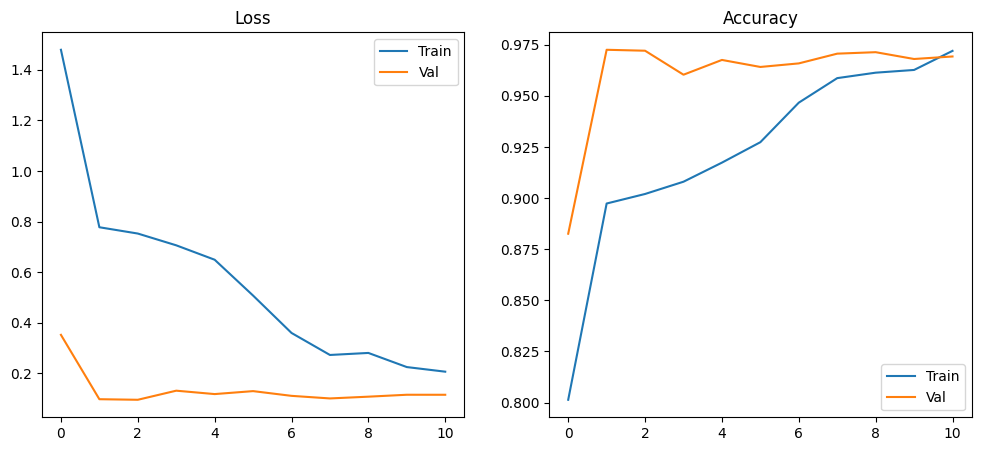

In [180]:
# ====================================================================
# CELL 15: PLOTS
# ====================================================================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
if 'val_loss' in history.history: plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
if 'val_accuracy' in history.history: plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy'); plt.legend()
plt.show()